In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
FullData = pd.read_csv("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/data/ProcessedData/AE_Prop_Time_Pivot_GLM_Data.csv")

In [3]:
def sanitize_column_names(df):
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('+', '_plus_') for col in df.columns]
    df.columns = [f"col_{col}" if col[0].isdigit() else col for col in df.columns]
    return df

In [4]:
ProportionalData = sanitize_column_names(FullData)

In [5]:
predictor_columns = ProportionalData.columns.difference(['Month', 'TotalAttendances', 'CovidPeriod'])
formula = 'TotalAttendances ~ ' + ' + '.join(predictor_columns) + ' + C(CovidPeriod)'
# Missing day of the week and time.

FullModel = smf.glm(formula=formula, 
                data=ProportionalData, 
                family=sm.families.Poisson(link=sm.families.links.log())).fit()

NullModel = smf.glm('TotalAttendances ~ 1', data = ProportionalData, family=sm.families.Poisson(link=sm.families.links.log())).fit()

log_likelihood_model = FullModel.llf
log_likelihood_null = NullModel.llf
mcfadden_r2 = 1 - (log_likelihood_model / log_likelihood_null)
print("Log-Liklihood:", log_likelihood_model)
print("McFadden's R^2:", mcfadden_r2)

print(FullModel.aic)
print(FullModel.bic)
# Display the model summary
print(FullModel.summary())

Log-Liklihood: -3571.3656999029918
McFadden's R^2: 0.9572122945600947
7220.7313998059835
6244.735938366771
                 Generalized Linear Model Regression Results                  
Dep. Variable:       TotalAttendances   No. Observations:                   60
Model:                            GLM   Df Residuals:                       21
Model Family:                 Poisson   Df Model:                           38
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3571.4
Date:                Sun, 24 Nov 2024   Deviance:                       6330.7
Time:                        14:31:55   Pearson chi2:                 6.34e+03
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------

/Users/chrisoldnall/anaconda3/envs/mypython/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/chrisoldnall/anaconda3/envs/mypython/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/chrisoldnall/anaconda3/envs/mypython/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generali

In [6]:
def interpret_glm_results(model):
    """
    This function generates a human-readable interpretation of the GLM results.
    
    Parameters:
    - model: The fitted GLM model object (from statsmodels).
    
    Returns:
    - A string summary interpreting the key results.
    """
    summary_lines = []
    
    # Extract the model parameters (coefficients), standard errors, and p-values
    params = model.params
    pvalues = model.pvalues
    conf_int = model.conf_int()

    summary_lines.append("GLM Summary:\n")
    
    # Interpret the Intercept (baseline)
    if 'Intercept' in params:
        intercept = params['Intercept']
        intercept_exp = np.exp(intercept)  # Exponentiate to get the effect in the original scale
        summary_lines.append(f"Baseline level (Intercept):\n")
        summary_lines.append(f"- Log-transformed expected number of attendances: {intercept:.4f}\n")
        summary_lines.append(f"- Expected number of attendances (exponentiated): {intercept_exp:.2f}\n\n")
    
    # Loop over all variables, excluding the intercept
    for variable in params.index:
        if variable == 'Intercept':
            continue  # Skip intercept
        
        coef = params[variable]
        coef_exp = np.exp(coef)  # Exponentiated coefficient to get the multiplicative effect
        p_value = pvalues[variable]
        conf_lower, conf_upper = conf_int.loc[variable]

        # Variable effect interpretation
        summary_lines.append(f"Variable: {variable}\n")
        summary_lines.append(f"- Coefficient (log scale): {coef:.3f}\n")
        summary_lines.append(f"- Exponentiated coefficient (effect on attendance): {coef_exp:.3f}\n")

        # Statistical significance
        if p_value < 0.001:
            summary_lines.append(f"- P-value: {p_value:.5f} (highly significant)\n")
        elif p_value < 0.05:
            summary_lines.append(f"- P-value: {p_value:.5f} (significant)\n")
        else:
            summary_lines.append(f"- P-value: {p_value:.5f} (not significant)\n")

        # Confidence Interval interpretation
        summary_lines.append(f"- 95% Confidence Interval (log scale): [{conf_lower:.3f}, {conf_upper:.3f}]\n")
        summary_lines.append(f"- 95% Confidence Interval (exponentiated): [{np.exp(conf_lower):.3f}, {np.exp(conf_upper):.3f}]\n\n")
    
    return ''.join(summary_lines)


interpretation = interpret_glm_results(FullModel)

# Print the interpretation summary
print(interpretation)

with open('/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/coldnall/results/glm_interpretation_new.txt', 'w') as f:
    f.write(interpretation)

GLM Summary:
Baseline level (Intercept):
- Log-transformed expected number of attendances: 5.3844
- Expected number of attendances (exponentiated): 217.98

Variable: C(CovidPeriod)[T.2]
- Coefficient (log scale): 0.039
- Exponentiated coefficient (effect on attendance): 1.040
- P-value: 0.00000 (highly significant)
- 95% Confidence Interval (log scale): [0.029, 0.050]
- 95% Confidence Interval (exponentiated): [1.029, 1.051]

Variable: C(CovidPeriod)[T.3]
- Coefficient (log scale): 0.001
- Exponentiated coefficient (effect on attendance): 1.001
- P-value: 0.86346 (not significant)
- 95% Confidence Interval (log scale): [-0.012, 0.014]
- 95% Confidence Interval (exponentiated): [0.989, 1.014]

Variable: C(CovidPeriod)[T.4]
- Coefficient (log scale): -0.114
- Exponentiated coefficient (effect on attendance): 0.892
- P-value: 0.00000 (highly significant)
- 95% Confidence Interval (log scale): [-0.127, -0.101]
- 95% Confidence Interval (exponentiated): [0.880, 0.904]

Variable: ED
- Coeffi

In [7]:
ProportionalData.columns

Index(['Month', 'TotalAttendances', 'CovidPeriod', 'Female', 'Male',
       'UnknownSex', 'col_18_24', 'col_25_39', 'col_40_64', 'col_65_74',
       'col_75_plus', 'Under_18', 'UnknownAge', 'SIMD1', 'SIMD2', 'SIMD3',
       'SIMD4', 'SIMD5', 'UnknownSIMD', 'ED', 'MIU', 'S08000015', 'S08000016',
       'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024',
       'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030',
       'S08000031', 'S08000032', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'sin_month', 'cos_month', 'Time'],
      dtype='object')

In [8]:
covid_dummies = pd.get_dummies(ProportionalData['CovidPeriod'], prefix='CovidPeriod')
ProportionalData = pd.concat([ProportionalData, covid_dummies], axis=1)

In [9]:
# Calculate differences in proportions for the relevant variables
variables_sex = ['Female', 'Male', 'UnknownSex']
variables_age = ['col_18_24', 'col_25_39', 'col_40_64', 'col_65_74', 'col_75_plus', 'Under_18', 'UnknownAge']
variables_simd = ['SIMD1', 'SIMD2', 'SIMD3', 'SIMD4', 'SIMD5', 'UnknownSIMD']
variables_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
variables_ae = ['ED', 'MIU']
variables_hb = ['S08000015', 'S08000016', 'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024', 'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030','S08000031', 'S08000032']

# Function to calculate differences and pad with 0 for the first row
def calculate_differences(df, variables):
    differences = df[variables].diff().fillna(0)  # First row difference set to 0
    return differences

# Add differences to the dataframe
ProportionalData[[var + 'diff' for var in variables_sex]] = calculate_differences(ProportionalData, variables_sex)
ProportionalData[[var + 'diff' for var in variables_age]] = calculate_differences(ProportionalData, variables_age)
ProportionalData[[var + 'diff' for var in variables_simd]] = calculate_differences(ProportionalData, variables_simd)
ProportionalData[[var + 'diff' for var in variables_day]] = calculate_differences(ProportionalData, variables_day)
ProportionalData[[var + 'diff' for var in variables_ae]] = calculate_differences(ProportionalData, variables_ae)
ProportionalData[[var + 'diff' for var in variables_hb]] = calculate_differences(ProportionalData, variables_hb)

In [10]:
coefficients = {
    # Sex variables
    'Female': 2.397,
    'Male': 1.904,
    'UnknownSex': 1.083,

    # Age variables
    'col_18_24': 1.835,
    'col_25_39': -4.517,
    'col_40_64': 1.955,
    'col_65_74': -0.643,
    'col_75_plus': 3.722,
    'Under_18': 1.950,
    'UnknownAge': 1.083,

    # SIMD variables
    'SIMD1': 0.920,
    'SIMD2': 2.386,
    'SIMD3': -2.264,
    'SIMD4': -7.183,
    'SIMD5': 5.385,
    'UnknownSIMD': 6.140,

    # Day variables
    'Monday': 1.773,
    'Tuesday': -0.142,
    'Wednesday': 1.365,
    'Thursday': 0.855,
    'Friday': 0.842,
    'Saturday': 0.162,
    'Sunday': 0.529,

    # Department type
    'ED': 2.009,
    'MIU': 3.375,

    # Health board variables
    'S08000015': 6.935,
    'S08000016': -16.488,
    'S08000017': -8.110,
    'S08000019': 9.921,
    'S08000020': -9.998,
    'S08000022': -0.931,
    'S08000024': -8.540,
    'S08000025': 50.545,
    'S08000026': -29.525,
    'S08000028': 3.149,
    'S08000029': -4.233,
    'S08000030': 5.209,
    'S08000031': 5.936,
    'S08000032': 1.515
}

In [11]:
# Function to calculate net effects
def calculate_net_effect(df, variables, coefficients):
    effects = sum(df[var + 'diff'] * coefficients[var] for var in variables)
    return np.exp(effects)  # Exponentiate the sum

# Net effects for each category
ProportionalData['NetEffectSex'] = calculate_net_effect(ProportionalData, variables_sex, coefficients)
ProportionalData['NetEffectAge'] = calculate_net_effect(ProportionalData, variables_age, coefficients)
ProportionalData['NetEffectSIMD'] = calculate_net_effect(ProportionalData, variables_simd, coefficients)
ProportionalData['NetEffectDay'] = calculate_net_effect(ProportionalData, variables_day, coefficients)
ProportionalData['NetEffectAE'] = calculate_net_effect(ProportionalData, variables_ae, coefficients)
ProportionalData['NetEffectHB'] = calculate_net_effect(ProportionalData, variables_hb, coefficients)

In [20]:
min(ProportionalData['NetEffectHB'])

0.7619436245665898

In [12]:
ProportionalData['Year'] = ProportionalData['Month'].astype(str).str[:4].astype(int)
ProportionalData['Month'] = ProportionalData['Month'].astype(str).str[4:6].astype(int)
ProportionalData['Day'] = 1
ProportionalData['Date'] = pd.to_datetime(ProportionalData[['Year', 'Month', 'Day']])

In [13]:
ProportionalData['CovidPeriod'].unique()

array([1, 4, 2, 3])

In [14]:
covid_irr = {1: 1.000, 2: 1.040, 3: 1.001, 4: 0.892}
ProportionalData['NetEffectCovidIRR'] = ProportionalData['CovidPeriod'].map(covid_irr)

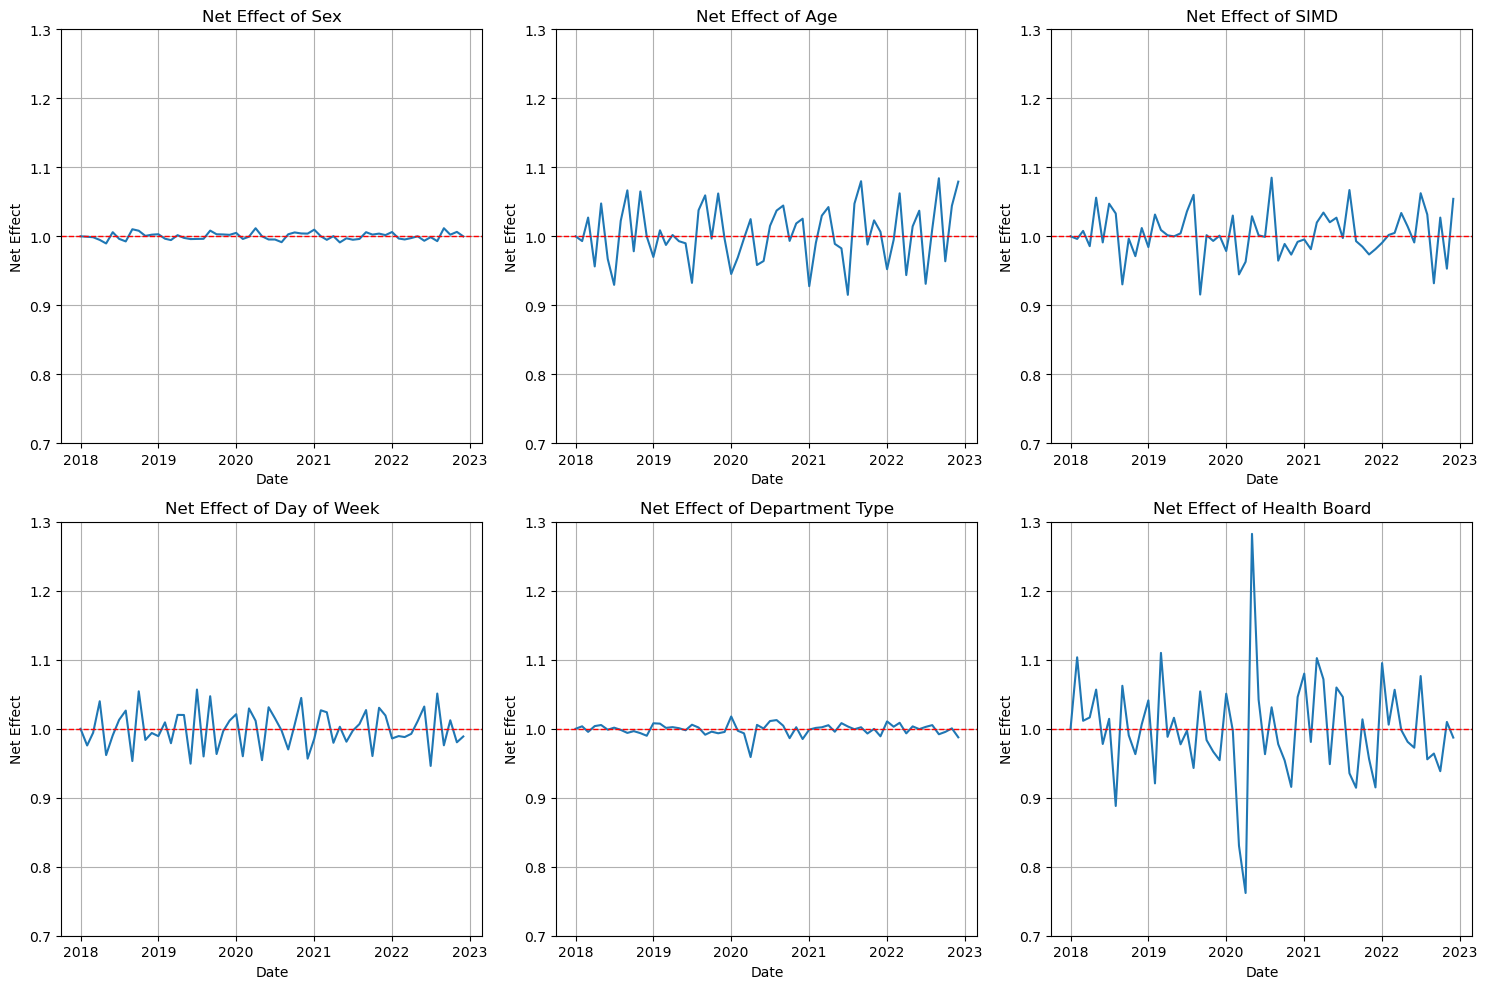

In [15]:
import matplotlib.pyplot as plt

# Assuming `data` contains the net effect columns for each variable group
# Example net effect columns: 'NetEffectSex', 'NetEffectAge', 'NetEffectSIMD', etc.
# Example time column: 'Date'

# Create a figure and axis array for 2 x 3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust size as needed

# List of plots: (y-axis column, title)
plots = [
    ('NetEffectSex', 'Net Effect of Sex'),
    ('NetEffectAge', 'Net Effect of Age'),
    ('NetEffectSIMD', 'Net Effect of SIMD'),
    ('NetEffectDay', 'Net Effect of Day of Week'),
    ('NetEffectAE', 'Net Effect of Department Type'),
    ('NetEffectHB', 'Net Effect of Health Board')
]

# Plot each variable in the grid
for ax, (col, title) in zip(axes.flatten(), plots):
    ax.plot(ProportionalData['Date'], ProportionalData[col], label=title)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Reference (y=1)')
    ax.set_ylim(0.7, 1.3)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Net Effect')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig("NetEffect_Grid.svg", format="svg", dpi=300)

# Show the plot
plt.show()

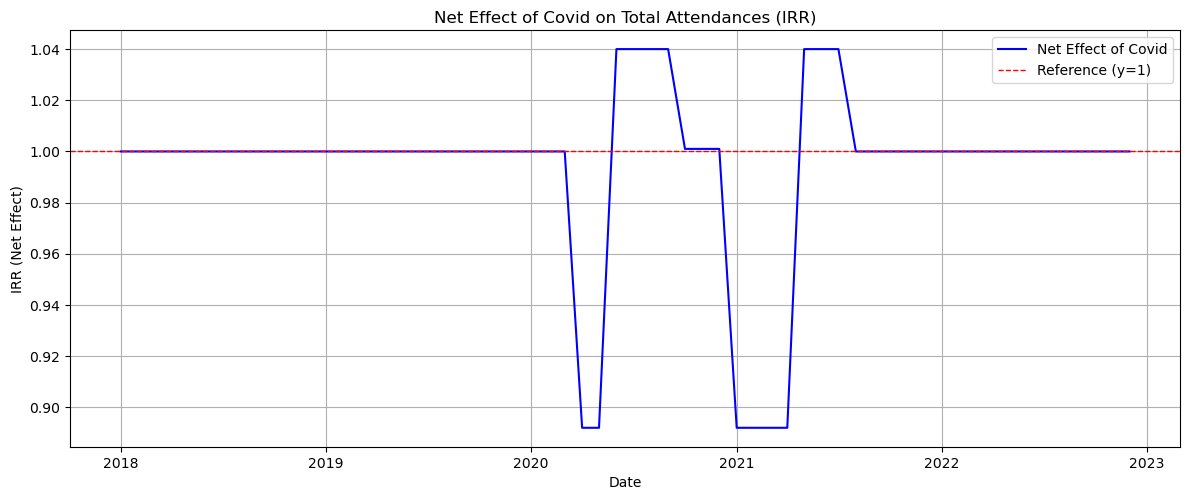

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define the figure and gridspec layout
fig = plt.figure(figsize=(12, 10))  # Adjust size as needed
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1])  # 3 rows, 2 columns

# Plot the Covid net effect (thin and tall)
ax0 = fig.add_subplot(gs[0, :])  # Span across both columns
ax0.plot(ProportionalData['Date'], ProportionalData['NetEffectCovidIRR'], label='Net Effect of Covid', color='blue')
ax0.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Reference (y=1)')
ax0.set_title("Net Effect of Covid on Total Attendances (IRR)")
ax0.set_xlabel("Date")
ax0.set_ylabel("IRR (Net Effect)")
ax0.legend()
ax0.grid(True)

# Define the other plots and their data
plots = [
    ('NetEffectSex', 'Net Effect of Sex'),
    ('NetEffectAge', 'Net Effect of Age'),
    ('NetEffectSIMD', 'Net Effect of SIMD'),
    ('NetEffectDay', 'Net Effect of Day of Week'),
    ('NetEffectAE', 'Net Effect of Department Type'),
    ('NetEffectHB', 'Net Effect of Health Board')
]

# Add the other 6 plots
axes = []
for i, (col, title) in enumerate(plots):
    ax.plot(ProportionalData['Date'], ProportionalData[col], label=title)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Reference (y=1)')
    ax.set_ylim(0.7, 1.3)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Net Effect')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
plt.savefig("NetEffect_Grid_Covid.svg", format="svg", dpi=300)
plt.show()

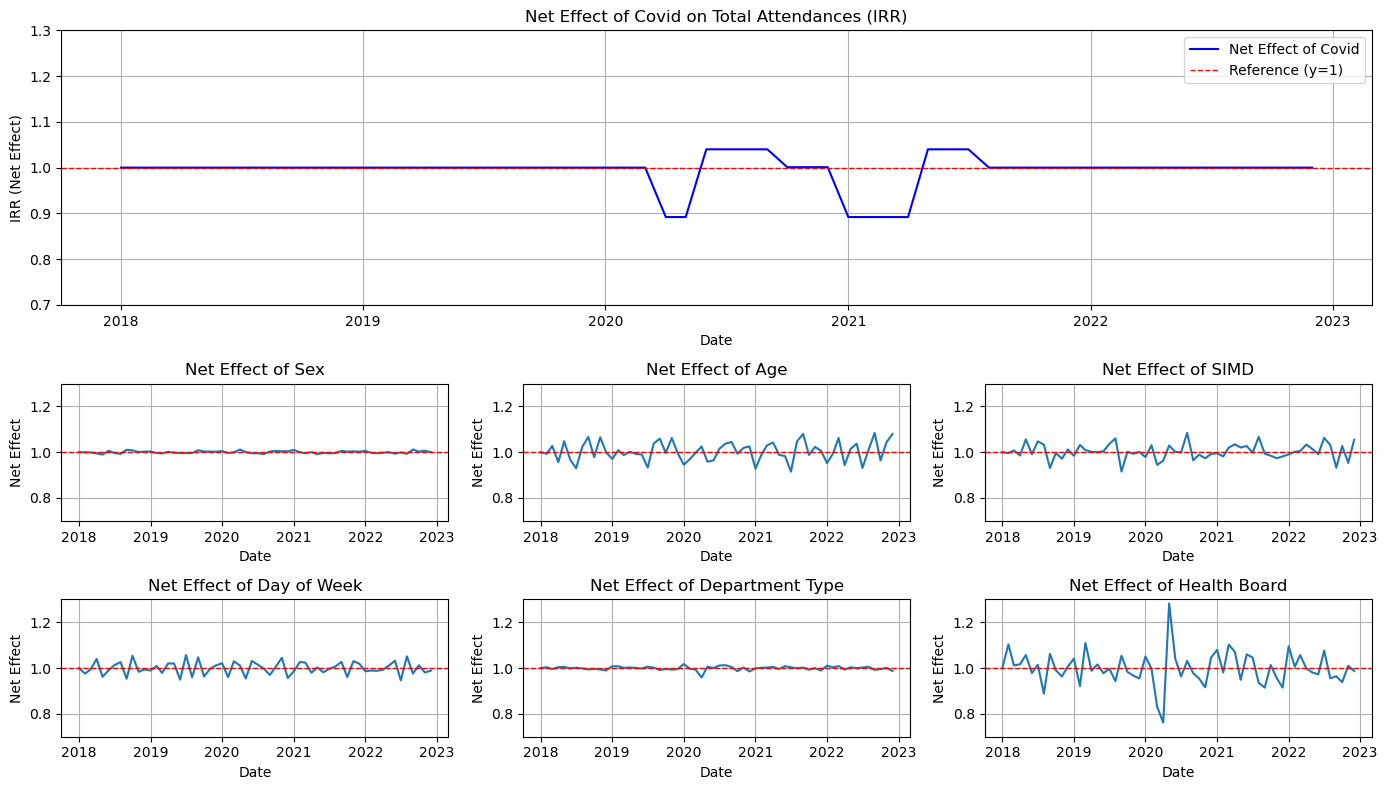

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define the figure and gridspec layout
fig = plt.figure(figsize=(14, 8))  # Reduce height to squash the plot
gs = gridspec.GridSpec(3, 3, height_ratios=[2, 1, 1])  # 3 rows, 3 columns; taller Covid plot

# Plot the Covid net effect (spanning the full width of the first row)
ax0 = fig.add_subplot(gs[0, :])  # First row, spans all three columns
ax0.plot(ProportionalData['Date'], ProportionalData['NetEffectCovidIRR'], label='Net Effect of Covid', color='blue')
ax0.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Reference (y=1)')
ax0.set_title("Net Effect of Covid on Total Attendances (IRR)")
ax0.set_ylim(0.7, 1.3)
ax0.set_xlabel("Date")
ax0.set_ylabel("IRR (Net Effect)")
ax0.legend()
ax0.grid(True)

# Define the other plots and their data
plots = [
    ('NetEffectSex', 'Net Effect of Sex'),
    ('NetEffectAge', 'Net Effect of Age'),
    ('NetEffectSIMD', 'Net Effect of SIMD'),
    ('NetEffectDay', 'Net Effect of Day of Week'),
    ('NetEffectAE', 'Net Effect of Department Type'),
    ('NetEffectHB', 'Net Effect of Health Board')
]

# Add the other 6 plots in a 2x3 grid
for i, (col, title) in enumerate(plots):
    ax = fig.add_subplot(gs[1 + i // 3, i % 3])  # Rows 2 and 3, three columns per row
    ax.plot(ProportionalData['Date'], ProportionalData[col], label=title)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1)
    ax.set_ylim(0.7, 1.3)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Net Effect")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("NetEffect_Grid_Covid_Squashed.png", format="png", dpi=300)
plt.show()